# Import

In [1]:
import numpy as np
import math
import itertools 
import pandas as pd
import numpy as np
import io
import msoffcrypto
from sklearn.metrics import r2_score
import openpyxl
import plotly.express as px
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import plotly
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import streamlit as st
import json
from math import factorial as fact
from IPython.display import Markdown, display
import networkx as nx
import requests
import toml
import sys, os

%matplotlib inline 
%config Completer.use_jedi = False

In [2]:
from types import SimpleNamespace

# Tiled import

## Data

In [2]:
with open('VALEO_1.tmj', 'r') as f:
  data = json.load(f)

In [3]:
dfs = pd.DataFrame(data['layers'][1]['objects']).drop(columns= ['rotation','width','height','visible','gid']).rename(columns = {'class' : 'Class', 'name' : 'Name'})
dfs.x = (dfs.x/16).astype(int)
dfs.y = (dfs.y/16).astype(int) - 1
dfs['Color'] = dfs['Class'].map({'C':10,'EV':20,'TP':30})
dfs

,Class,id,Name,x,y,Color
0,C,41,3,3,5,10
1,C,38,2,6,2,10
2,C,40,1,0,2,10
3,C,39,0,3,0,10
4,EV,42,1,4,2,20
5,EV,43,0,2,7,20
6,TP,44,1,2,2,30
7,TP,45,0,1,7,30


In [4]:
dfline  = pd.DataFrame(data['layers'][2]['objects']).drop(columns=['rotation','width','name','height','visible']).rename(columns = {'class' : 'Class'})

for idx, row in dfline.iterrows():
    properties = row.properties
    dfline.loc[idx, ['end','long','start']] = [d['value'] for d in properties]    
    polyline = row.polyline
    x = row.x
    y = row.y
    polyline = [(p['x'] + x, p['y'] + y) for p in polyline]
    dfline.at[idx , 'polyline'] = polyline
dfline.start = pd.to_numeric(dfline.start)
dfline.end = pd.to_numeric(dfline.end)
dfline = dfline.drop(columns= ['properties','x','y'])

## plot all

In [267]:
N = data['height']
A0 = data['layers'][0]['data']
A0 = np.array(A0).reshape(10,7)
pas = 16
unique = np.unique(A0)
A0[A0 == unique[0]] = 0
A0[A0 == unique[1]] = 1
A0

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0]])

In [268]:
for idx, row in dfs.iterrows():
#     print(row.x, row.y , row.Type * int(row.name))
    A0[row.y, row.x] = row.Type + int(row.Name)

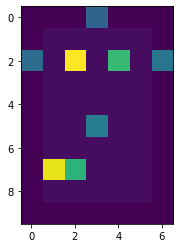

In [269]:
fig, ax = plt.subplots()
ax.imshow(A0)

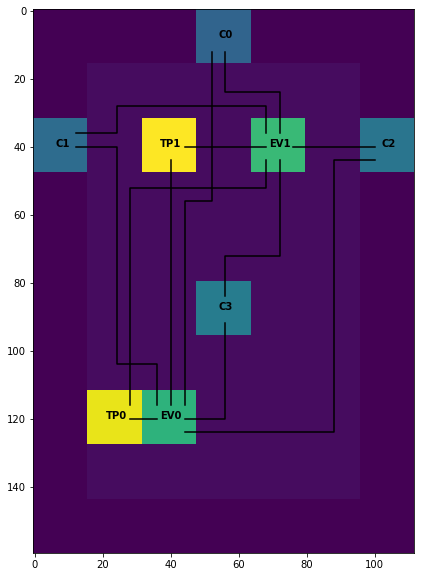

In [270]:
A = np.kron(A0, np.ones((16,16), dtype=int))
fig, ax = plt.subplots(figsize = (10,10))
ax.imshow(A)
for idx, row in dfline.iterrows():
    p = np.array(row.polyline)
    f = ax.plot(p[:,0],p[:,1],'k')
style = dict(size=10, color='black')  
for idx, row in dfs.iterrows():
    x = row.x*16
    y = row.y*16
    text = row.Class + str(row.Name)
    f = ax.text(row.x*16+8, row.y*16+8,text , **style,  ha='center', weight='bold') 

## indiv

In [7]:
D = dfs.Class.value_counts().to_dict()

In [8]:
R = np.random.randint(0,D['EV'],D['C'])
R

array([1, 0, 1, 0])

In [9]:
dfline['Select'] = False
dfs['Connect'] = 0
dfs.loc[dfs.Class == 'C', 'Connect']= 1
for i in range(D['C']):
    j = R[i]
    mask = (dfline.Class == 'C-E') & (dfline.start == i) & (dfline.end == j)
    print(i,j, mask.sum())
    dfline.loc[mask, 'Select'] = True 
    
    mask = (dfs.Class == 'EV') & (dfs.Name == str(j))
    dfs.loc[mask, 'Connect'] +=  + 1
    
for i in np.unique(R):
    j = np.random.randint(0,D['TP'])
    mask = (dfline.Class == 'P-E') & (dfline.start == j) & (dfline.end == i)
    print(i,j, mask.sum())
    dfline.loc[mask, 'Select'] = True
    
    mask = (dfs.Class == 'TP') & (dfs.Name == str(j))
    dfs.loc[mask, 'Connect'] +=  + 1
    
dfline  
dfs

0 1 1
1 0 1
2 1 1
3 0 1
0 0 1
1 1 1


,Class,id,polyline,end,long,start,Select
0,P-E,6,"[(28, 120), (36, 120)]",0,1.0,0,True
1,P-E,7,"[(40, 44), (40, 116)]",0,2.0,1,False
2,P-E,8,"[(44, 40), (68, 40)]",1,1.0,1,True
3,P-E,12,"[(28, 116), (28, 52), (68, 52), (68, 44)]",1,3.0,0,False
4,C-E,4,"[(56, 12), (56, 24), (72, 24), (72, 36)]",1,1.0,0,True
5,C-E,10,"[(100, 44), (88, 44), (88, 124), (44, 124)]",0,3.0,2,False
6,C-E,2,"[(12, 40), (24, 40), (24, 104), (36, 104), (36...",0,3.0,1,True
7,C-E,5,"[(100, 40), (76, 40)]",1,1.0,2,True
8,C-E,13,"[(52, 12), (52, 56), (44, 56), (44, 116)]",0,4.0,0,False
9,C-E,14,"[(12, 36), (24, 36), (24, 28), (68, 28), (68, ...",1,2.0,1,False


,Class,id,Name,x,y,Color,Connect
0,C,41,3,3,5,10,1
1,C,38,2,6,2,10,1
2,C,40,1,0,2,10,1
3,C,39,0,3,0,10,1
4,EV,42,1,4,2,20,2
5,EV,43,0,2,7,20,2
6,TP,44,1,2,2,30,1
7,TP,45,0,1,7,30,1


In [10]:
N = data['height']
A0 = data['layers'][0]['data']
A0 = np.array(A0).reshape(10,7)
pas = 16
unique = np.unique(A0)
A0[A0 == unique[0]] = 0
A0[A0 == unique[1]] = 1
for idx, row in dfs.iterrows():
    if row.Connect > 0:
        A0[row.y, row.x] = row.Color + int(row.Name)
A0        

array([[ 0,  0,  0, 10,  0,  0,  0],
       [ 0,  1,  1,  1,  1,  1,  0],
       [11,  1, 31,  1, 21,  1, 12],
       [ 0,  1,  1,  1,  1,  1,  0],
       [ 0,  1,  1,  1,  1,  1,  0],
       [ 0,  1,  1, 13,  1,  1,  0],
       [ 0,  1,  1,  1,  1,  1,  0],
       [ 0, 30, 20,  1,  1,  1,  0],
       [ 0,  1,  1,  1,  1,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0]])

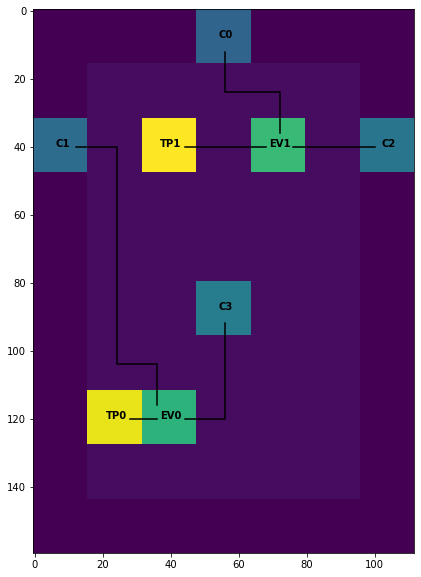

In [11]:
A = np.kron(A0, np.ones((16,16), dtype=int))
fig, ax = plt.subplots(figsize = (10,10))
ax.imshow(A)
for idx, row in dfline.iterrows():
    if row.Select: 
        p = np.array(row.polyline)
        f = ax.plot(p[:,0],p[:,1],'k')

style = dict(size=10, color='black') 
for idx, row in dfs.iterrows():
    if row.Connect > 0:
        x = row.x*16
        y = row.y*16
        text = row.Class + str(row.Name)
        f = ax.text(row.x*16+8, row.y*16+8,text , **style,  ha='center', weight='bold') 

In [258]:
Elist = np.unique(R)
Elist
R = np.random.randint(0,D['EV'],D['C'])

array([0, 1])

In [256]:
pd.value_counts(R).sort_index()

0    3
1    1
dtype: int64

In [207]:
ci = pd.DataFrame({'EV':ce}).T
ci.columns.name = 'C'
ci

C,0,1,2,3
EV,1,1,1,0


In [217]:
ep = pd.value_counts(ce).sort_index()
ep.name = 'Count'
ep= ep.to_frame()
ep

ep['TP'] = np.random.randint(0,D['TP'],len(ep))
ep

,Count
0,1
1,3


,Count,TP
0,1,0
1,3,0


In [214]:
ci
ep.T

C,0,1,2,3
EV,1,1,1,0


,1,0
Count,3,1
TP,1,0


In [ ]:
indivs = {}
for i in range(10):
    r = np.random.randint()
    
    break
    
    
    

In [187]:
np.unique(C,
          return_index=True,
          return_inverse=True,
          return_counts=True,axis = 1)

(array([[0, 0, 0, 1],
        [0, 1, 1, 0],
        [0, 1, 1, 1],
        [0, 0, 1, 1],
        [0, 1, 0, 1],
        [0, 1, 1, 0],
        [1, 1, 0, 1],
        [0, 0, 0, 0],
        [0, 0, 1, 1],
        [1, 1, 0, 1]]),
 array([1, 2, 3, 0], dtype=int64),
 array([3, 0, 1, 2], dtype=int64),
 array([1, 1, 1, 1], dtype=int64))

In [183]:

np.unique(E[0],
          return_index=True,
          return_inverse=True,
          return_counts=True,)

(array([0, 1]),
 array([1, 0], dtype=int64),
 array([1, 0, 0, 1], dtype=int64),
 array([2, 2], dtype=int64))

In [ ]:
n = 0
i = c.copy()


In [157]:
n = 0

i = c.copy()
j = C[n]
l = list(zip(i,j))
dist1 = dfc[dfc.ij.isin(l)].dist.tolist()
dc = {
    'i' : i,
    'j' : j,
    'dist' : dist1}
dc


i = C[n]
j = E[n]
l = list(zip(i,j))
dist2 = [dfe[dfe.ij == ij].dist.iloc[0] for ij in l]
indiv = np.vstack([c,C[n],dist1,E[n],dist2])

rank = round(sum(dist1) + sum(dist2),2)
rank

{'i': [0, 1, 2], 'j': array([1, 1, 0]), 'dist': [2.83, 2.0, 4.12]}

16.61

# LATEX

In [3]:
%%latex
$sin(x)/x$

$C^{k-1}_{n+k-1} = \frac{(n+k-1)!}{n! (k-1)!}$

<IPython.core.display.Latex object>

In [6]:
%%latex
$Nslot ^ {Ncapteur}$

<IPython.core.display.Latex object>

In [4]:
%%latex
$\sum u_{n}$ ; $\sum_{i=1}^{n} (v_{i-1}+u_{i})$ 

<IPython.core.display.Latex object>

# Reseau

## NX

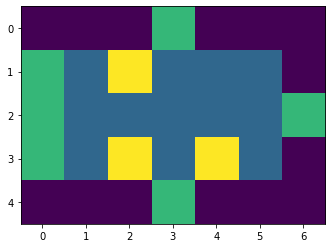

In [18]:
plt.imshow(np.flip(A, axis=0))

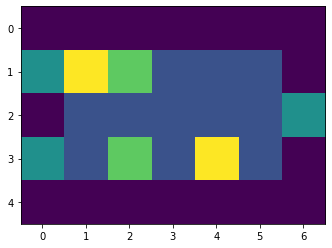

In [171]:
A = pd.read_excel('pattern.xlsx',header = None).values

A = np.flip(A.T, axis=0)
plt.imshow(A)

In [3]:
S = list(zip(*np.where(A==1)))
C = tuple(zip(*np.where(A==2)))
PosSlots = ['S'+ str(i) for i in range(len(S))]
PosSlots = dict(zip(PosSlots,S))

PosCapt = ['C'+ str(i) for i in range(len(C))]
PosCapt = dict(zip(PosCapt,C))

PosTotal = PosSlots.copy()
PosTotal.update(PosCapt)
PosTotal

{'S0': (0, 3),
 'S1': (1, 0),
 'S2': (2, 0),
 'S3': (2, 6),
 'S4': (3, 0),
 'S5': (4, 3),
 'C0': (1, 2),
 'C1': (1, 4),
 'C2': (3, 2)}

In [5]:
comb = list(itertools.combinations(list(PosTotal.keys()),2))
dist = {}
for edge in comb:
    x1,x2 = edge
    dist[edge] = round(math.dist(PosTotal[x1],PosTotal[x2]),2)
dist

{('S0', 'S1'): 3.16,
 ('S0', 'S2'): 3.61,
 ('S0', 'S3'): 3.61,
 ('S0', 'S4'): 4.24,
 ('S0', 'S5'): 4.0,
 ('S0', 'C0'): 1.41,
 ('S0', 'C1'): 1.41,
 ('S0', 'C2'): 3.16,
 ('S1', 'S2'): 1.0,
 ('S1', 'S3'): 6.08,
 ('S1', 'S4'): 2.0,
 ('S1', 'S5'): 4.24,
 ('S1', 'C0'): 2.0,
 ('S1', 'C1'): 4.0,
 ('S1', 'C2'): 2.83,
 ('S2', 'S3'): 6.0,
 ('S2', 'S4'): 1.0,
 ('S2', 'S5'): 3.61,
 ('S2', 'C0'): 2.24,
 ('S2', 'C1'): 4.12,
 ('S2', 'C2'): 2.24,
 ('S3', 'S4'): 6.08,
 ('S3', 'S5'): 3.61,
 ('S3', 'C0'): 4.12,
 ('S3', 'C1'): 2.24,
 ('S3', 'C2'): 4.12,
 ('S4', 'S5'): 3.16,
 ('S4', 'C0'): 2.83,
 ('S4', 'C1'): 4.47,
 ('S4', 'C2'): 2.0,
 ('S5', 'C0'): 3.16,
 ('S5', 'C1'): 3.16,
 ('S5', 'C2'): 1.41,
 ('C0', 'C1'): 2.0,
 ('C0', 'C2'): 2.0,
 ('C1', 'C2'): 2.83}

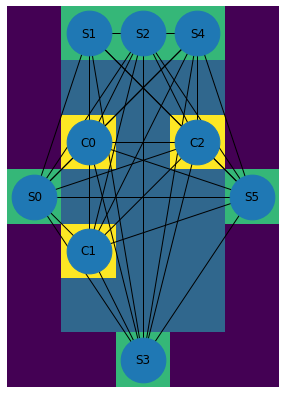

In [27]:
G = nx.Graph()
G.add_nodes_from([(node, {'pos': v}) for (node, v) in PosTotal.items()])
# G.nodes(data=True)
for (u,v),d in dist.items():
    G.add_edge(u, v, dist=d)

fig, ax = plt.subplots(figsize = (5,7))
# nx.draw(G,  with_labels=True)
ax.imshow(A.T)
nx.draw(G, nx.get_node_attributes(G, 'pos'), with_labels=True, node_size=2000,  ax=ax)

#connectionstyle="arc3,rad=-0.3" par edge pour faire style 

## Combinatoire NEWS !!! 

In [38]:
slot = ['S1','S2','S3']
capteurs = ['C1','C2']

In [39]:
# combinaison reseau interne on prend pas le full connected sert a rien 
slot = list(range(Smax))
lst = [x for l in range(len(slot)) for x in itertools.combinations(ListSlots, l)]
len(lst), Smax, Smax*(Smax-1)/2
lst

NameError: name 'Smax' is not defined

In [299]:
[l for l in range(Nslot)]

[0, 1, 2]

In [123]:
n = 5
r = 2
comb = list(itertools.combinations(list(range(n)), r))
len(comb) , fact(n)/(fact(r) * fact(n-r))

(10, 10.0)

In [40]:
Nslot = 5
Ncapteur = 3
r = 2 #connexions par 2 
ListSlots = list(range(Nslot))

# connexion entre chaque slot possible = graph complete 
ListCombSlots = list(itertools.combinations(ListSlots, r))
CombMaxSlot = fact(Nslot)/(fact(r) * fact(Nslot-r))


lst = [x for l in range(Nslot) for x in itertools.combinations(ListSlots, l)]
CombMaxSlot2 = [fact(Nslot)/(fact(l) * fact(Nslot-l) ) for l in range(Nslot)]
CombMaxSlot2 = sum(CombMaxSlot2)

ListCombCapteurs = list(itertools.product(ListSlots,repeat = Ncapteur))
CombMaxCapteurs = Nslot ** Ncapteur

len(ListCombSlots) , CombMaxSlot
len(lst) ,CombMaxSlot2
len(ListCombCapteurs) , CombMaxCapteurs

# [ListCombSlots ,ListCombCapteurs]

ListCombTotal = list(itertools.product(*[ListCombSlots ,ListCombCapteurs]))
len(ListCombTotal), CombMaxSlot * CombMaxCapteurs

(10, 10.0)

(31, 31.0)

(125, 125)

(1250, 1250.0)

## save combinatoire precise des capteurs 

In [136]:
Smax = 3
slot = list(range(Smax))
comb = list(itertools.product(slot,repeat =2))
len(comb)
a = np.array(comb)
a

9

array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]])

In [111]:
L= []
for i in range(Smax):
    L.append((a == i).sum(1))
counts = np.vstack(L).T  
counts

array([[2, 0, 0],
       [1, 1, 0],
       [1, 0, 1],
       [1, 1, 0],
       [0, 2, 0],
       [0, 1, 1],
       [1, 0, 1],
       [0, 1, 1],
       [0, 0, 2]])

## Method on fixe les slots

In [ ]:
indiv = ['T1','T2','E1','E2']
capteurs = ['C1','C2']
lst = [indiv,capteurs]

In [ ]:

sx = list(itertools.combinations(indiv,2))
cx = list(itertools.permutations(capteurs,2))
sx
cx
comb  = list(itertools.product(*[sx,cx]))
comb

In [ ]:
pd.DataFrame(comb)

# Test nx

In [ ]:
import math
s = np.where(A==1)
import itertools 
comb = list(itertools.combinations(['S1','S2','S3'] + ['C1','C2'],2))
dist = {}
for edge in comb:
    x1,x2 = edge
    dist[edge] = round(math.dist(pos[x1],pos[x2]),2)
dist

In [ ]:
[(node, {'pos': attr}) for (node, attr) in pos.items()]

In [ ]:
G = nx.Graph()
G.add_nodes_from([(node, {'pos': attr}) for (node, attr) in pos.items()])
G.nodes(data=True)
for (u,v),d in dist.items():
    G.add_edge(u, v, dist=d)

# nx.draw(G,  with_labels=True)
nx.draw(G, nx.get_node_attributes(G, 'pos'), with_labels=True)

In [ ]:
S = tuple(zip(*np.where(A==1)))
S
C = tuple(zip(*np.where(A==2)))
S = dict(zip(['S1','S2','S3'],S))
C = dict(zip(['C1','C2'],C))
G = nx.complete_graph(S)
nx.draw(G,  with_labels=True)
G.edges
G.nodes(data=True)

In [ ]:
itertools.combinations(iterable, r)

In [ ]:
x , y = np.where(A==1)
print(np.sqrt((x1 - x0) ** 2 + (y1 - y0) ** 2))

In [ ]:
from scipy.spatial.distance import cdist
dist = cdist(s[0],s[1])

In [ ]:
from scipy.spatial.distance import euclidean
s = np.where(A==1)
s
euclidean(s[0],s[1])

In [ ]:
dict(nx.all_pairs_shortest_path(G))

In [ ]:
G = nx.Graph()
G.add_edges_from([(1,2), (1,3), (2,3), (2,4), (3,4)])
nx.draw(G,  with_labels=True)
path = nx.all_pairs_shortest_path_length(G) # This is a generator
dpath = {x[0]:x[1] for x in path} 
dpath
nx.floyd_warshall_numpy(G)

In [ ]:
distances = nx.floyd_warshall_numpy(G)
nodes = np.where(distances==2)
distances
nodes

In [ ]:
G = nx.path_graph(5)
nx.draw(G,  with_labels=True)

In [ ]:
s = np.where(A==1)
s
np.diff(s[0])

In [ ]:
np.linalg.norm(np.where(A==2))

In [ ]:
indiv = {0: {
    1: {"len": 1},
    2: {"len": 3}
}}  # single edge (0,1)
indiv
G = nx.from_dict_of_dicts(indiv)
nx.draw(G,  with_labels=True)

In [ ]:
nx.enumerate_all_cliques(G)

In [ ]:
import networkx as nx

G = nx.Graph()

# G.add_node('Hamburg', pos=(53.5672, 10.0285))
# G.add_node('Berlin', pos=(52.51704, 13.38792))
G.add_node('A', pos=(5, 1))
G.add_node('B', pos=(1, 5))
G.add_node('C', pos=(1, 3))
G.add_node('D', pos=(3, 3))
G=nx.complete_graph(['S1','S2','S3','S4'])
G = nx.complete_graph(4, nx.DiGraph())
nx.draw(G, with_labels=True)
# fig = nx.draw(G, nx.get_node_attributes(G, 'pos'), with_labels=True, node_size=0)

In [ ]:
fig

In [ ]:
pos = {city:(long, lat) for (city, (lat,long)) in nx.get_node_attributes(G, 'pos').items()}
pos
nx.draw(G, pos, with_labels=True, node_size=0)

# GA

## Import Tab

In [75]:
edges = pd.read_excel('pattern.xlsx',sheet_name='edges')
nodes = pd.read_excel('pattern.xlsx',sheet_name='nodes')
edges.head()
nodes

,i,j,d
0,0,A,0.5
1,0,B,5.0
2,0,0,0.2
3,0,1,1.0
4,0,2,4.0


,Name,Type,x,y
0,A,c,0,2
1,B,c,2,0
2,0,e,2,2
3,1,mix,4,0
4,2,mix,0,4


In [ ]:
Cnames = ['A','B']
Enames = []

In [ ]:
c = {}
for k,v in edges.iterrows():
    if 
    

In [ ]:
Enames  = nodes[['e','mix'])].name.tolist()
Cnames = nodes[nodes.type == 'c'].name.tolist()

In [79]:
E = nodes[nodes.Type.isin(['e','mix'])].set_index('Name')[['x','y']].to_dict(orient= 'index')
C = nodes[nodes.Type.isin(['c'])].set_index('Name')[['x','y']].to_dict(orient= 'index')
P = nodes[nodes.Type.isin(['p','mix'])].set_index('Name')[['x','y']].to_dict(orient= 'index')

In [83]:
edges.groupby('j').i.unique()

j
0    [0, 1, 2, 3]
1    [0, 1, 2, 3]
2    [0, 1, 2, 3]
A    [0, 1, 2, 3]
B    [0, 1, 2, 3]
Name: i, dtype: object

In [81]:

for i in edges.i.unique():
    print(i)

0
1
2
3


In [60]:
ListNodeMix  = nodes[['e','mix'])].name.tolist()
ListCapteurs = nodes[nodes.type == 'c'].name.tolist()
Nc = len(ListCapteurs)
Ne = len(ListNodeMix)
Np = len(ListNodeMix)
c = list(range(Nc))
e = list(range(Ne))
p = list(range(Np))

C = np.random.randint(0,Ne,(10,Nc))
C

array([[1, 0],
       [0, 2],
       [0, 2],
       [1, 1],
       [0, 0],
       [0, 1],
       [2, 1],
       [2, 1],
       [0, 2],
       [1, 2]])

### IniPop

In [62]:
#IniPop
C = np.random.randint(0,Ne,(10,Nc))
E = np.random.randint(0,Np,(10,Ne))
C
E

array([[2, 0],
       [0, 1],
       [0, 0],
       [2, 1],
       [2, 2],
       [2, 1],
       [2, 2],
       [0, 2],
       [2, 1],
       [1, 0]])

array([[1, 2, 1],
       [0, 0, 0],
       [1, 2, 0],
       [1, 1, 0],
       [0, 1, 0],
       [1, 2, 0],
       [0, 2, 0],
       [2, 0, 1],
       [1, 2, 0],
       [2, 0, 2]])

### Graph

In [36]:
G = nx.Graph()
G.add_nodes_from(df.j.unique())
for idx , row in df.iterrows():
    u,v,d = row.values
    G.add_edge(u, v, dist=d)

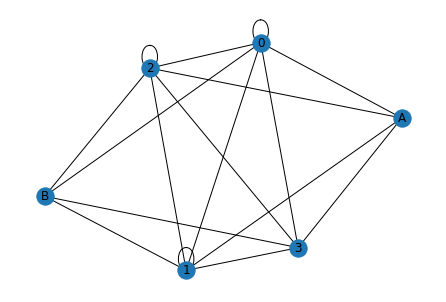

In [37]:
nx.draw(G, with_labels=True)

## INI

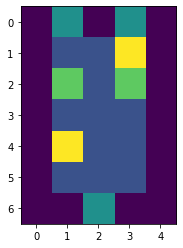

In [150]:
A = pd.read_excel('pattern.xlsx',header = None).values
plt.imshow(A)

In [151]:
from types import SimpleNamespace
dict_algo = {'pop': 10,
             'epoch': 10,
             'shortcut_pool': 0.1,
             'ChromCount': 0,
             #'Stat_T': [],
             'All_indivs': []
             }
nalgo = SimpleNamespace(**{str(k): v for k, v in dict_algo.items()})

In [152]:
T = list(zip(*np.where(A==3)))
E = list(zip(*np.where(A==2)))
C = tuple(zip(*np.where(A==1)))
DictPos = {}
Types = ['C','E','P']
D = {}
for i in range(3):    
    Type = Types[i]
    pos = list(zip(*np.where(A==i+1)))
    names  = [Type+ str(i) for i in range(len(pos))]
    D[Type] = pos    
#     DictPos.update(dict(zip(names,pos)))
D
# DictPos

{'C': [(0, 1), (0, 3), (6, 2)], 'E': [(2, 1), (2, 3)], 'P': [(1, 3), (4, 1)]}

In [153]:
Nc = len(D['C'])
Ne = len(D['E'])
Np = len(D['P'])
c = list(range(Nc))
e = list(range(Ne))
p = list(range(Np))

In [154]:
Comb = list(itertools.product(*[c ,e]))
c_e = []
for d in Comb:
    i, j = d
    x1 = D['C'][i]
    x2 = D['E'][j]
    dist = round(math.dist(x1,x2),2)
    c_e.append([i,j,(i,j),x1,x2,dist])

Comb = list(itertools.product(*[e ,p]))
e_p = []
for d in Comb:
    i, j = d
    x1 = D['E'][i]
    x2 = D['P'][j]
    dist = round(math.dist(x1,x2),2)
    e_p.append([i,j,(i,j),x1,x2,dist])
c_e
e_p

[[0, 0, (0, 0), (0, 1), (2, 1), 2.0],
 [0, 1, (0, 1), (0, 1), (2, 3), 2.83],
 [1, 0, (1, 0), (0, 3), (2, 1), 2.83],
 [1, 1, (1, 1), (0, 3), (2, 3), 2.0],
 [2, 0, (2, 0), (6, 2), (2, 1), 4.12],
 [2, 1, (2, 1), (6, 2), (2, 3), 4.12]]

[[0, 0, (0, 0), (2, 1), (1, 3), 2.24],
 [0, 1, (0, 1), (2, 1), (4, 1), 2.0],
 [1, 0, (1, 0), (2, 3), (1, 3), 1.0],
 [1, 1, (1, 1), (2, 3), (4, 1), 2.83]]

In [155]:
dfc = pd.DataFrame(c_e, columns = ['i','j','ij','x1','x2','dist'])
dfe = pd.DataFrame(e_p, columns = ['i','j','ij','x1','x2','dist'])
dfc
dfe

,i,j,ij,x1,x2,dist
0,0,0,"(0, 0)","(0, 1)","(2, 1)",2.00
1,0,1,"(0, 1)","(0, 1)","(2, 3)",2.83
2,1,0,"(1, 0)","(0, 3)","(2, 1)",2.83
3,1,1,"(1, 1)","(0, 3)","(2, 3)",2.00
4,2,0,"(2, 0)","(6, 2)","(2, 1)",4.12
5,2,1,"(2, 1)","(6, 2)","(2, 3)",4.12


,i,j,ij,x1,x2,dist
0,0,0,"(0, 0)","(2, 1)","(1, 3)",2.24
1,0,1,"(0, 1)","(2, 1)","(4, 1)",2.00
2,1,0,"(1, 0)","(2, 3)","(1, 3)",1.00
3,1,1,"(1, 1)","(2, 3)","(4, 1)",2.83


In [156]:
C = np.random.randint(0,Ne,(10,Nc))
E = np.random.randint(0,Np,(10,Nc))
C
E

array([[1, 1, 0],
       [0, 1, 0],
       [1, 0, 1],
       [0, 1, 0],
       [1, 0, 1],
       [1, 0, 1],
       [0, 0, 1],
       [1, 0, 1],
       [0, 0, 1],
       [1, 1, 0]])

array([[1, 1, 1],
       [0, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 1],
       [1, 1, 1],
       [1, 1, 0],
       [0, 0, 1]])

In [157]:
n = 0

i = c.copy()
j = C[n]
l = list(zip(i,j))
dist1 = dfc[dfc.ij.isin(l)].dist.tolist()
dc = {
    'i' : i,
    'j' : j,
    'dist' : dist1}
dc


i = C[n]
j = E[n]
l = list(zip(i,j))
dist2 = [dfe[dfe.ij == ij].dist.iloc[0] for ij in l]
indiv = np.vstack([c,C[n],dist1,E[n],dist2])

rank = round(sum(dist1) + sum(dist2),2)
rank

{'i': [0, 1, 2], 'j': array([1, 1, 0]), 'dist': [2.83, 2.0, 4.12]}

16.61

## NX

In [172]:
D

{'C': [(0, 1), (0, 3), (6, 2)], 'E': [(2, 1), (2, 3)], 'P': [(1, 3), (4, 1)]}

In [12]:
nodes = [] 
for k,v in D.items():
    k,v
    for i in range(len(v)):
        n = (k + str(i) , {'pos' : (v[i][1], v[i][0])})
        nodes.append(n)
nodes

('C', [(0, 1), (0, 3), (6, 2)])

('E', [(2, 1), (2, 3)])

('P', [(1, 3), (4, 1)])

[('C0', {'pos': (1, 0)}),
 ('C1', {'pos': (3, 0)}),
 ('C2', {'pos': (2, 6)}),
 ('E0', {'pos': (1, 2)}),
 ('E1', {'pos': (3, 2)}),
 ('P0', {'pos': (3, 1)}),
 ('P1', {'pos': (1, 4)})]

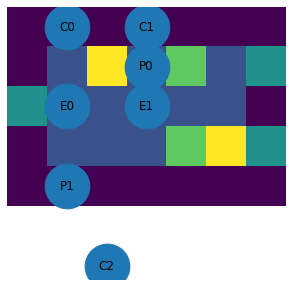

In [17]:
G = nx.Graph()
G.add_nodes_from(nodes)
fig, ax = plt.subplots(figsize = (5,7))
ax.imshow(np.flip(A.T,1))
nx.draw(G, nx.get_node_attributes(G, 'pos'), with_labels=True, node_size=2000,  ax=ax)

In [14]:
n = 0
i = C[n]
j = E[n]
l = list(zip(i,j))
i2 = ['C'+ str(i) for i in c]
j2 = ['E'+ str(i) for i in e]
l2 = list(zip(i2,j2))
dist2 = [dfe[dfe.ij == ij].dist.iloc[0] for ij in l]
for u,v in list(set(l2)):
    print(u,v)
    G.add_edge(u, v,dist = 0)

C1 E1
C0 E0


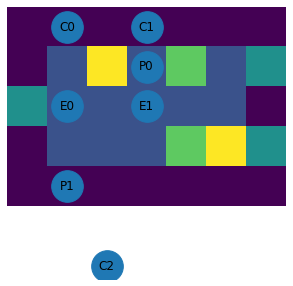

In [18]:
fig, ax = plt.subplots(figsize = (5,7))
ax.imshow(np.flip(A.T,1))
nx.draw(G, nx.get_node_attributes(G, 'pos'), with_labels=True, node_size=1000,  ax=ax)

In [ ]:
G = nx.Graph()
G.add_nodes_from([(node, {'pos': v}) for (node, v) in PosTotal.items()])
# G.nodes(data=True)
for (u,v),d in dist.items():
    G.add_edge(u, v, dist=d)

fig, ax = plt.subplots(figsize = (5,7))
# nx.draw(G,  with_labels=True)
ax.imshow(A.T)
nx.draw(G, nx.get_node_attributes(G, 'pos'), with_labels=True, node_size=2000,  ax=ax)

## NameSpace

In [121]:
[DictTypes['C'],DictTypes['E']]
a = DictTypes['C']
b = DictTypes['E']
Comb = list(itertools.product(*[a ,b]))
Comb
# list(itertools.combinations(Comb,2))
list(itertools.product(b,repeat=3))

[['C0', 'C1', 'C2'], ['E0', 'E1']]

[('C0', 'E0'),
 ('C0', 'E1'),
 ('C1', 'E0'),
 ('C1', 'E1'),
 ('C2', 'E0'),
 ('C2', 'E1')]

[('E0', 'E0', 'E0'),
 ('E0', 'E0', 'E1'),
 ('E0', 'E1', 'E0'),
 ('E0', 'E1', 'E1'),
 ('E1', 'E0', 'E0'),
 ('E1', 'E0', 'E1'),
 ('E1', 'E1', 'E0'),
 ('E1', 'E1', 'E1')]

In [45]:
Nc = 3
Ne = 2
Np = 2
C = np.random.randint(0,Ne,(10,Nc))

In [46]:
E = np.random.randint(0,Np,(10,Nc))
E

array([[0, 0, 1],
       [1, 1, 0],
       [1, 1, 1],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 1],
       [0, 0, 0],
       [0, 0, 1],
       [0, 0, 1]])

In [47]:
C
E

array([[1, 1, 1],
       [1, 0, 1],
       [1, 1, 1],
       [0, 1, 0],
       [1, 0, 1],
       [1, 0, 1],
       [0, 1, 0],
       [1, 1, 0],
       [0, 1, 0],
       [0, 1, 0]])

array([[0, 0, 1],
       [1, 1, 0],
       [1, 1, 1],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 1],
       [0, 0, 0],
       [0, 0, 1],
       [0, 0, 1]])

In [ ]:
np.vectorize(my_dict.__getitem__)(a)

In [ ]:
i = 0
c = C[i]
e = E[i]
Rank = 


In [114]:
pd.DataFrame(c)

,0,1,2
0,0,0,1
1,1,0,0
2,0,0,1
3,1,1,1
4,0,0,0
5,1,1,0
6,1,0,0
7,0,1,1
8,1,0,0
9,0,1,1


In [ ]:

nmax = 5
POP = 10
pop = np.zeros((nmax, nmax), dtype= int)
np.fill_diagonal(pop, 1)
p2 = np.tile(pop,(2,1))
r = np.where(p2 == 0)
np.random.choice(r)
# np.repeat(pop,[1, 2],1)
p2
# idx = np.random.randint(0,nmax,POP)
# pop[:,idx] = 1
# pop
p2[p2 == 0]


## test

In [91]:
c = np.random.randint(0,Ne+1,(10,Nc))

In [93]:
c
L= []
for i in range(3):
    L.append((c == i).sum(1))
e = np.vstack(L).T  
e

array([[1, 2, 0],
       [1, 1, 1],
       [2, 0, 0],
       [1, 1, 0],
       [0, 1, 1],
       [1, 0, 1],
       [0, 1, 1],
       [1, 1, 1],
       [0, 0, 0],
       [0, 0, 0]])

array([[1, 1, 1],
       [0, 3, 0],
       [2, 0, 1],
       [1, 2, 0],
       [1, 2, 0],
       [1, 2, 0],
       [1, 2, 0],
       [0, 3, 0],
       [3, 0, 0],
       [3, 0, 0]])

In [ ]:
np.random.randint(0,Ne+1,(10,Nc))

In [80]:
x = np.unique(c, return_counts = True)
np.array(x)

array([[0, 1, 2],
       [1, 1, 1]], dtype=int64)

In [82]:
dict(zip(np.array(x)))


ValueError: dictionary update sequence element #0 has length 1; 2 is required

In [55]:
import random as rand
Nc = len()
rand.randint(0,2)

2

In [29]:
nalgo

namespace(pop=10, epoch=10, shortcut_pool=0.1, ChromCount=0, All_indivs=[])

In [ ]:
SimpleNamespace()

In [30]:
class Individual(object):
    def __init__(self, c,e,t):

#         nalgo.All_indivs.append(chrom)
        nalgo.ChromCount+=1
        #print( nalgo.ChromCount)
        self.c = chrom
        self.Rank = 0
        self.stat = {}
        self.Modif = True

    def print(self):
        print('Chrom ', self.Chrom)

    def get_rank(self):
        return self.Rank

# ANcien

## test

In [ ]:

nmax = 5
POP = 10
pop = np.zeros((nmax, nmax), dtype= int)
np.fill_diagonal(pop, 1)
p2 = np.tile(pop,(2,1))
r = np.where(p2 == 0)
np.random.choice(r)
# np.repeat(pop,[1, 2],1)
p2
# idx = np.random.randint(0,nmax,POP)
# pop[:,idx] = 1
# pop
p2[p2 == 0]


## exemple

In [6]:
# Python3 implementation of the above approach
from random import randint

INT_MAX = 2147483647
# Number of cities in TSP
V = 5

# Names of the cities
GENES = "ABCDE"

# Starting Node Value
START = 0

# Initial population size for the algorithm
POP_SIZE = 10

# Structure of a GNOME
# defines the path traversed
# by the salesman while the fitness value
# of the path is stored in an integer


class individual:
	def __init__(self) -> None:
		self.gnome = ""
		self.fitness = 0

	def __lt__(self, other):
		return self.fitness < other.fitness

	def __gt__(self, other):
		return self.fitness > other.fitness


# Function to return a random number
# from start and end
def rand_num(start, end):
	return randint(start, end-1)


# Function to check if the character
# has already occurred in the string
def repeat(s, ch):
	for i in range(len(s)):
		if s[i] == ch:
			return True

	return False


# Function to return a mutated GNOME
# Mutated GNOME is a string
# with a random interchange
# of two genes to create variation in species
def mutatedGene(gnome):
	gnome = list(gnome)
	while True:
		r = rand_num(1, V)
		r1 = rand_num(1, V)
		if r1 != r:
			temp = gnome[r]
			gnome[r] = gnome[r1]
			gnome[r1] = temp
			break
	return ''.join(gnome)


# Function to return a valid GNOME string
# required to create the population
def create_gnome():
	gnome = "0"
	while True:
		if len(gnome) == V:
			gnome += gnome[0]
			break

		temp = rand_num(1, V)
		if not repeat(gnome, chr(temp + 48)):
			gnome += chr(temp + 48)

	return gnome


# Function to return the fitness value of a gnome.
# The fitness value is the path length
# of the path represented by the GNOME.
def cal_fitness(gnome):
	mp = [
		[0, 2, INT_MAX, 12, 5],
		[2, 0, 4, 8, INT_MAX],
		[INT_MAX, 4, 0, 3, 3],
		[12, 8, 3, 0, 10],
		[5, INT_MAX, 3, 10, 0],
	]
	f = 0
	for i in range(len(gnome) - 1):
		if mp[ord(gnome[i]) - 48][ord(gnome[i + 1]) - 48] == INT_MAX:
			return INT_MAX
		f += mp[ord(gnome[i]) - 48][ord(gnome[i + 1]) - 48]

	return f


# Function to return the updated value
# of the cooling element.
def cooldown(temp):
	return (90 * temp) / 100


# Comparator for GNOME struct.
# def lessthan(individual t1,
#			 individual t2)
# :
#	 return t1.fitness < t2.fitness


# Utility function for TSP problem.
def TSPUtil(mp):
	# Generation Number
	gen = 1
	# Number of Gene Iterations
	gen_thres = 5

	population = []
	temp = individual()

	# Populating the GNOME pool.
	for i in range(POP_SIZE):
		temp.gnome = create_gnome()
		temp.fitness = cal_fitness(temp.gnome)
		population.append(temp)

	print("\nInitial population: \nGNOME	 FITNESS VALUE\n")
	for i in range(POP_SIZE):
		print(population[i].gnome, population[i].fitness)
	print()

	found = False
	temperature = 10000

	# Iteration to perform
	# population crossing and gene mutation.
	while temperature > 1000 and gen <= gen_thres:
		population.sort()
		print("\nCurrent temp: ", temperature)
		new_population = []

		for i in range(POP_SIZE):
			p1 = population[i]

			while True:
				new_g = mutatedGene(p1.gnome)
				new_gnome = individual()
				new_gnome.gnome = new_g
				new_gnome.fitness = cal_fitness(new_gnome.gnome)

				if new_gnome.fitness <= population[i].fitness:
					new_population.append(new_gnome)
					break

				else:
					# Accepting the rejected children at
					# a possible probability above threshold.
					prob = pow(
						2.7,
						-1
						* (
							(float)(new_gnome.fitness - population[i].fitness)
							/ temperature
						),
					)
					if prob > 0.5:
						new_population.append(new_gnome)
						break

		temperature = cooldown(temperature)
		population = new_population
		print("Generation", gen)
		print("GNOME	 FITNESS VALUE")

		for i in range(POP_SIZE):
			print(population[i].gnome, population[i].fitness)
		gen += 1




mp = [
    [0, 2, INT_MAX, 12, 5],
    [2, 0, 4, 8, INT_MAX],
    [INT_MAX, 4, 0, 3, 3],
    [12, 8, 3, 0, 10],
    [5, INT_MAX, 3, 10, 0],
]
TSPUtil(mp)



Initial population: 
GNOME	 FITNESS VALUE

041320 2147483647
041320 2147483647
041320 2147483647
041320 2147483647
041320 2147483647
041320 2147483647
041320 2147483647
041320 2147483647
041320 2147483647
041320 2147483647


Current temp:  10000
Generation 1
GNOME	 FITNESS VALUE
031420 2147483647
043120 2147483647
014320 2147483647
031420 2147483647
031420 2147483647
041230 2147483647
031420 2147483647
042310 21
021340 2147483647
043120 2147483647

Current temp:  9000.0
Generation 2
GNOME	 FITNESS VALUE
042130 32
031240 32
034120 2147483647
014230 2147483647
031240 32
041320 2147483647
042130 32
021430 2147483647
012340 24
034120 2147483647

Current temp:  8100.0
Generation 3
GNOME	 FITNESS VALUE
013240 21
012430 31
013240 21
013240 21
042310 21
032140 2147483647
012430 31
041230 2147483647
031420 2147483647
024130 2147483647

Current temp:  7290.0
Generation 4
GNOME	 FITNESS VALUE
012340 24
012340 24
043210 24
012340 24
012340 24
042130 32
031240 32
021430 2147483647
034120 214748364

# Combinatoire brut force  (a trier)

https://forums.futura-sciences.com/mathematiques-college-lycee/193661-repartir-n-objets-k-boites.html

https://fr.wikipedia.org/wiki/Combinaison_(math%C3%A9matiques)

In [ ]:

num = np.math.factorial(20)/np.math.factorial(10)
print(f"{num:,}")

In [ ]:
"qefqze : {:,.0f}".format(num)

In [ ]:
from math import factorial as f
enumerate

In [ ]:
d0 = {'Slot' : 3,'Capteur' : 4, 'elements' : 2}
d0.values()

In [ ]:
f(n)/(f(k))

A = f(n)/f(n-k)
A

In [ ]:
f(3)

In [ ]:
f(3)

In [ ]:
2**3
1**4
f(3)/f(1)

In [ ]:
slot = 2
capteur = 3

k = slot
n =capteur
n+k-1
n,k-1

a = f(n+k-1)
b = f(n) * f(k-1)
COMBINAISON = int(a/b)
print(a, b,a/b)


In [ ]:
from datetime import timedelta

def get_time_hh_mm_ss(sec):
    # create timedelta and convert it into string
    td_str = str(timedelta(seconds=sec))
    print('Time in seconds:', sec)

    # split string into individual component
    x = td_str.split(':')
    print(td_str)
    print('Time in hh:mm:ss:', x[0], 'Hours', x[1], 'Minutes', x[2], 'Seconds')

get_time_hh_mm_ss(29500000)
get_time_hh_mm_ss(num)